# Deep Learning models

In [ ]:
import polars as pl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load data
df_long = pl.read_parquet("../data/processed_data/df_long.parquet")
pdf = df_long.sort(["Drink", "Date"]).to_pandas()
pdf["Date"] = pd.to_datetime(pdf["Date"])

# Feature engineering (same as ML models)
pdf["year"] = pdf["Date"].dt.year
pdf["month"] = pdf["Date"].dt.month
pdf["dayofweek"] = pdf["Date"].dt.dayofweek
pdf["is_weekend"] = (pdf["dayofweek"] >= 5).astype(int)

pdf["lag1"] = pdf.groupby("Drink")["Views"].shift(1)
pdf["lag7"] = pdf.groupby("Drink")["Views"].shift(7)
pdf["lag14"] = pdf.groupby("Drink")["Views"].shift(14)

pdf["roll7_mean"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)
pdf["roll7_std"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=2).std())
)
pdf["roll7_std"] = pdf["roll7_std"].fillna(0.0)

pdf = pdf.dropna(subset=["lag1", "lag7", "lag14"])

# Train/Test split
cutoff = pd.Timestamp(2025, 1, 1)
train_pdf = pdf[pdf["Date"] < cutoff].copy()
test_pdf = pdf[pdf["Date"] >= cutoff].copy()

# One-hot encode
train_pdf = pd.get_dummies(train_pdf, columns=["Drink"], drop_first=False)
test_pdf = pd.get_dummies(test_pdf, columns=["Drink"], drop_first=False)
test_pdf = test_pdf.reindex(columns=train_pdf.columns, fill_value=0)

# Extract features
target = "Views"
feature_cols = [c for c in train_pdf.columns if c not in ["Views", "Date"]]

X_train = train_pdf[feature_cols].values
y_train = train_pdf[target].values
X_test = test_pdf[feature_cols].values
y_test = test_pdf[target].values

# Impute NaNs
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Train shape: (16310, 19), Test shape: (3350, 19)
y_train shape: (16310,), y_test shape: (3350,)


In [ ]:
test = pd.read_parquet("../data/fourier+trend+holidays_test.parquet")

## Data Scaling for Neural Networks
Normalize features and targets for better training stability.

In [3]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"X_train scaled: {X_train_scaled.shape}")
print(f"y_train scaled: {y_train_scaled.shape}")

X_train scaled: (16310, 19)
y_train scaled: (16310,)


## Deep Learning Models
Train Dense, LSTM, GRU, and 1D CNN models using Keras/TensorFlow.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress TF warnings
tf.get_logger().setLevel('ERROR')

def evaluate(actual, pred, name):
    """Compute evaluation metrics"""
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred) / np.clip(actual, 1e-8, None))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "name": name}

# Store results
results_dl = {}
preds_store_dl = {}

# 1. Dense Neural Network
print("Training Dense Neural Network...")
model_dense = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_dense.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_dense.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, 
                validation_split=0.2, verbose=0)
pred_dense_scaled = model_dense.predict(X_test_scaled, verbose=0).flatten()
pred_dense = scaler_y.inverse_transform(pred_dense_scaled.reshape(-1, 1)).flatten()
results_dl["Dense_NN"] = evaluate(y_test, pred_dense, "Dense_NN")
preds_store_dl["Dense_NN"] = pred_dense
print("✓ Dense NN done")

# 2. LSTM
print("Training LSTM...")
# Reshape for LSTM (samples, timesteps, features)
look_back = 7
X_train_lstm = np.array([X_train_scaled[i-look_back:i] for i in range(look_back, len(X_train_scaled))])
X_test_lstm = np.array([X_test_scaled[i-look_back:i] for i in range(look_back, len(X_test_scaled))])
y_train_lstm = y_train_scaled[look_back:]
y_test_lstm = y_test_scaled[look_back:]

model_lstm = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
               validation_split=0.2, verbose=0)
pred_lstm_scaled = model_lstm.predict(X_test_lstm, verbose=0).flatten()
pred_lstm = scaler_y.inverse_transform(pred_lstm_scaled.reshape(-1, 1)).flatten()
# Align with y_test by padding
pred_lstm_full = np.concatenate([np.full(look_back, np.nan), pred_lstm])[:len(y_test)]
results_dl["LSTM"] = evaluate(y_test[look_back:], pred_lstm, "LSTM")
preds_store_dl["LSTM"] = pred_lstm_full
print("✓ LSTM done")

# 3. GRU
print("Training GRU...")
model_gru = keras.Sequential([
    layers.GRU(64, activation='relu', input_shape=(look_back, X_train_scaled.shape[1]), return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_gru.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
              validation_split=0.2, verbose=0)
pred_gru_scaled = model_gru.predict(X_test_lstm, verbose=0).flatten()
pred_gru = scaler_y.inverse_transform(pred_gru_scaled.reshape(-1, 1)).flatten()
pred_gru_full = np.concatenate([np.full(look_back, np.nan), pred_gru])[:len(y_test)]
results_dl["GRU"] = evaluate(y_test[look_back:], pred_gru, "GRU")
preds_store_dl["GRU"] = pred_gru_full
print("✓ GRU done")

# 4. 1D CNN
print("Training 1D CNN...")
# Reshape for 1D CNN
X_train_cnn = X_train_scaled[:-1].reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled[:-1].reshape(-1, X_test_scaled.shape[1], 1)
y_train_cnn = y_train_scaled[1:]
y_test_cnn = y_test_scaled[1:]

model_cnn = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    layers.Dropout(0.2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, 
              validation_split=0.2, verbose=0)
pred_cnn_scaled = model_cnn.predict(X_test_cnn, verbose=0).flatten()
pred_cnn = scaler_y.inverse_transform(pred_cnn_scaled.reshape(-1, 1)).flatten()
pred_cnn_full = np.concatenate((np.array([np.nan]), pred_cnn))[:len(y_test)]
results_dl["CNN_1D"] = evaluate(y_test[1:], pred_cnn, "CNN_1D")
preds_store_dl["CNN_1D"] = pred_cnn_full
print("✓ 1D CNN done")

print("\nAll models trained successfully!")

Training Dense Neural Network...


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Dense NN done
Training LSTM...


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

## Model Comparison
Compare DL models using metrics table and visualizations.


DEEP LEARNING MODEL COMPARISON (lower is better):
                 MAE        RMSE                 MAPE
CNN_1D    279.829254  654.889757     82099354257.3237
GRU       755.593628  943.394469  517446926682.721802
Dense_NN   722.72345   988.56136  490070184895.261841
LSTM      778.561768  998.010771  603728607979.458252


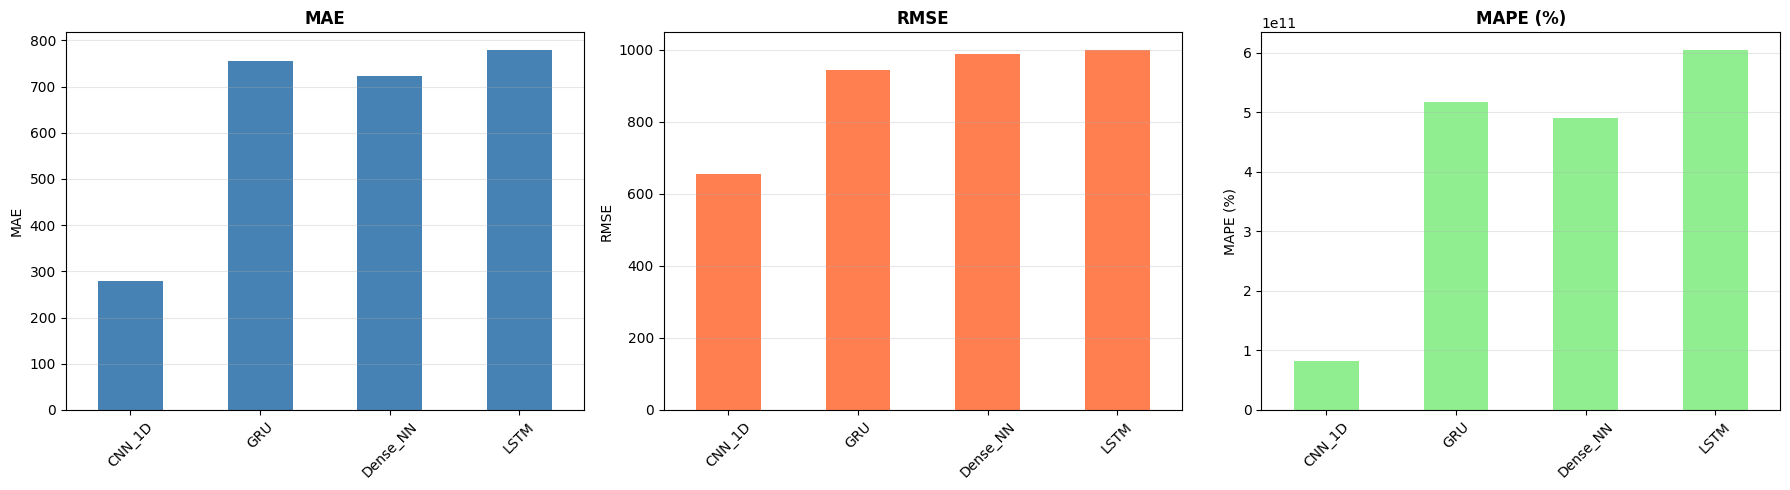

In [ ]:
# Create comparison DataFrame
comp_df_dl = pd.DataFrame(results_dl).T
comp_df_dl = comp_df_dl.sort_values("RMSE")
print("\nDEEP LEARNING MODEL COMPARISON (lower is better):")
print(comp_df_dl[["MAE", "RMSE", "MAPE"]].round(3))

# Bar charts of metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

comp_df_dl.plot(kind="bar", y="MAE", ax=axes[0], legend=False, color="steelblue")
axes[0].set_title("MAE", fontweight="bold")
axes[0].set_ylabel("MAE")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, alpha=0.3, axis="y")

comp_df_dl.plot(kind="bar", y="RMSE", ax=axes[1], legend=False, color="coral")
axes[1].set_title("RMSE", fontweight="bold")
axes[1].set_ylabel("RMSE")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3, axis="y")

comp_df_dl.plot(kind="bar", y="MAPE", ax=axes[2], legend=False, color="lightgreen")
axes[2].set_title("MAPE (%)", fontweight="bold")
axes[2].set_ylabel("MAPE (%)")
axes[2].tick_params(axis="x", rotation=45)
axes[2].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Top Models Overlay
Compare the best performing DL models against actual values.

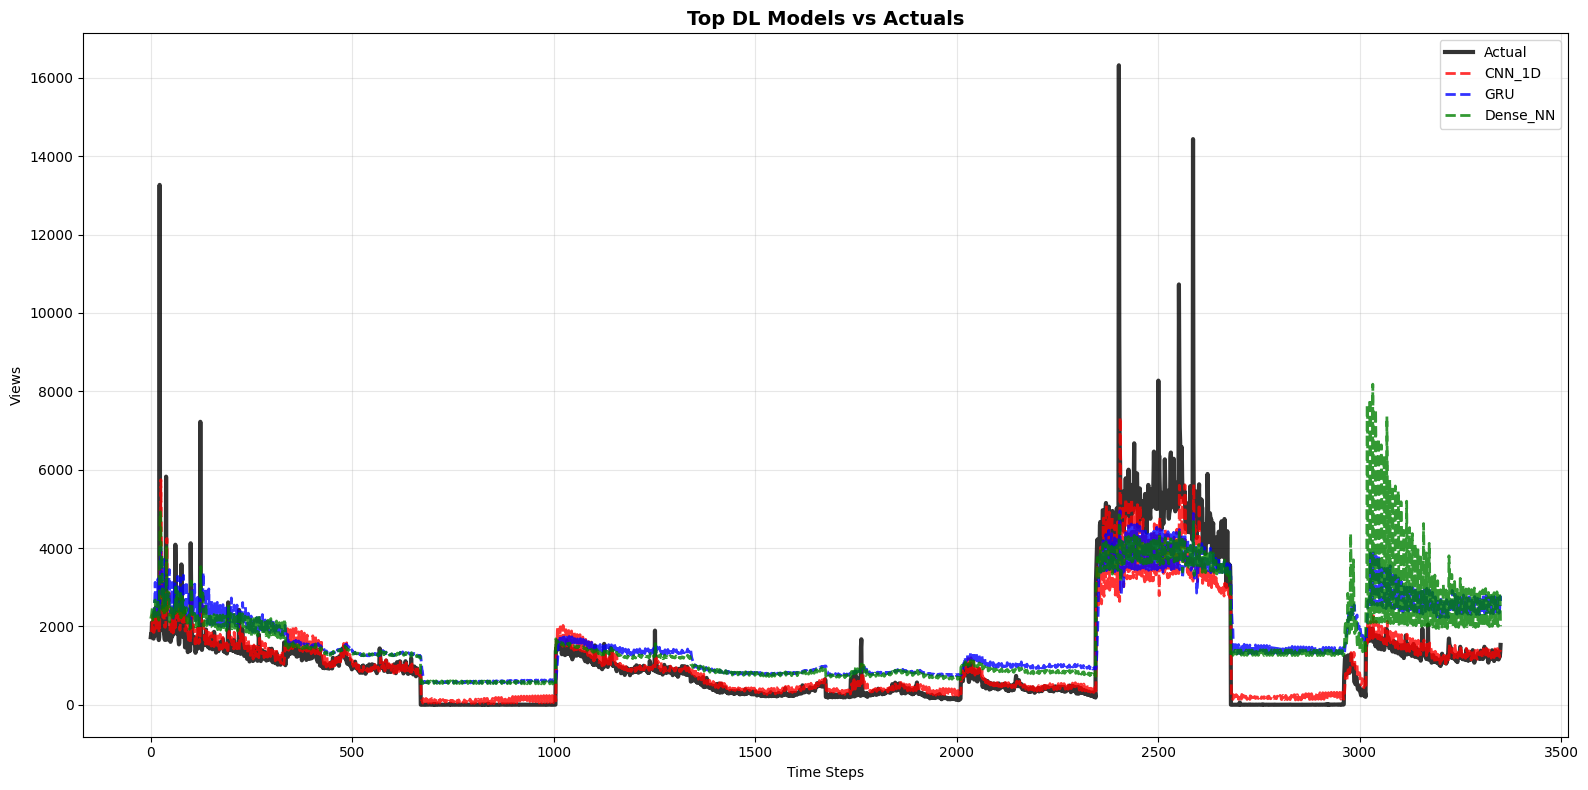

In [ ]:
# Top 3 models overlay plot
k = 3
best_models_dl = comp_df_dl.head(k).index.tolist()

plt.figure(figsize=(16, 8))
plt.plot(y_test, label="Actual", linewidth=3, color="black", alpha=0.8)
colors = ["red", "blue", "green", "orange", "purple"]
for i, name in enumerate(best_models_dl):
    pred = preds_store_dl[name]
    # Handle NaN values
    mask = ~np.isnan(pred)
    plt.plot(np.where(mask)[0], pred[mask], label=name, linestyle="--", alpha=0.8, linewidth=2, color=colors[i])

plt.title("Top DL Models vs Actuals", fontsize=14, fontweight="bold")
plt.xlabel("Time Steps")
plt.ylabel("Views")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Individual Model Performance
Detailed visualization of each DL model against actual values.

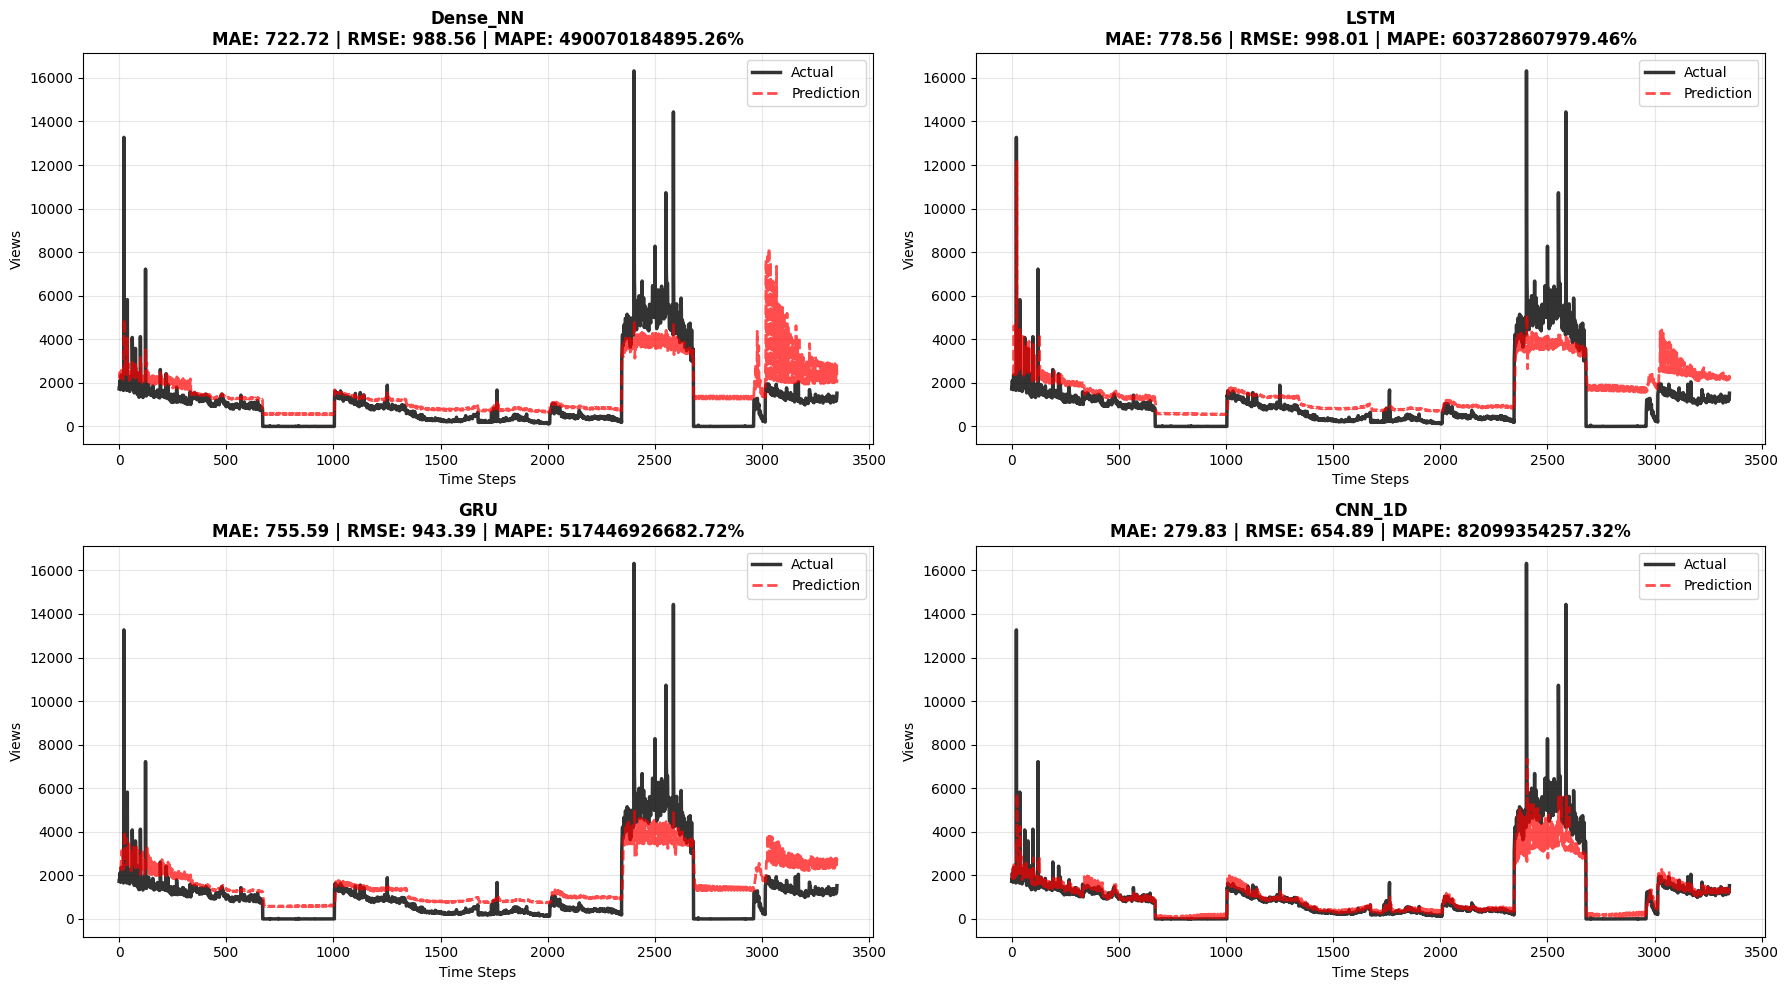

In [ ]:
# Create subplots for each DL model
num_models = len(preds_store_dl)
cols = 2
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for idx, (model_name, pred) in enumerate(preds_store_dl.items()):
    ax = axes[idx]
    
    # Plot actual
    ax.plot(y_test, label="Actual", linewidth=2.5, color="black", alpha=0.8)
    
    # Plot prediction (skip NaN values)
    mask = ~np.isnan(pred)
    ax.plot(np.where(mask)[0], pred[mask], label="Prediction", linestyle="--", linewidth=2, alpha=0.7, color="red")
    
    # Add metrics to subplot title
    mae = results_dl[model_name]["MAE"]
    rmse = results_dl[model_name]["RMSE"]
    mape = results_dl[model_name]["MAPE"]
    
    ax.set_title(f"{model_name}\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontweight="bold")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Views")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()